## MazeRunner DataAnalyse

# GROTE VRAGEN:

## - Vinden de multiagents sneller de uitgang als ze samenwerken (auction)


In [2]:
import os
import glob
import pyarrow.feather as feather

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sns.set(font_scale = 2)
# from analysis.helpers import plot_batch, read_data

In [3]:
os.getcwd()

os.chdir('../experiments')

os.getcwd()

'D:\\HU-Studie\\Jaar 3\\ABD\\MazeRunner\\experiments'

## Basis

Hierin kijken we welke van de 3 soorten agents in normale omstandigheden het stelste de uitgang vind. We kijken eerst naar een 'kleine' maze met afmetingen van 20x20 tiles, daarna naar een 2x grotere maze.

#### Klein doolhof

- Grootte: 20x20
- 100 batches per policy
- Slowness = 0
- Memory Decay = 0

In [128]:
df_lt = feather.read_feather('baseline/baseline_small/baseline_leaftracker_small.feather').assign(policy='leaftracker')
df_pf = feather.read_feather('baseline/baseline_small/baseline_pathfinder_small.feather').assign(policy='pathfinder')
df_pr = feather.read_feather('baseline/baseline_small/baseline_purerandom_small.feather').assign(policy='purerandom')


base_small_all = pd.concat([df_lt, df_pf, df_pr], axis=0).assign(size='small')
base_small_alive = base_small_all[base_small_all.found_exit != -1]

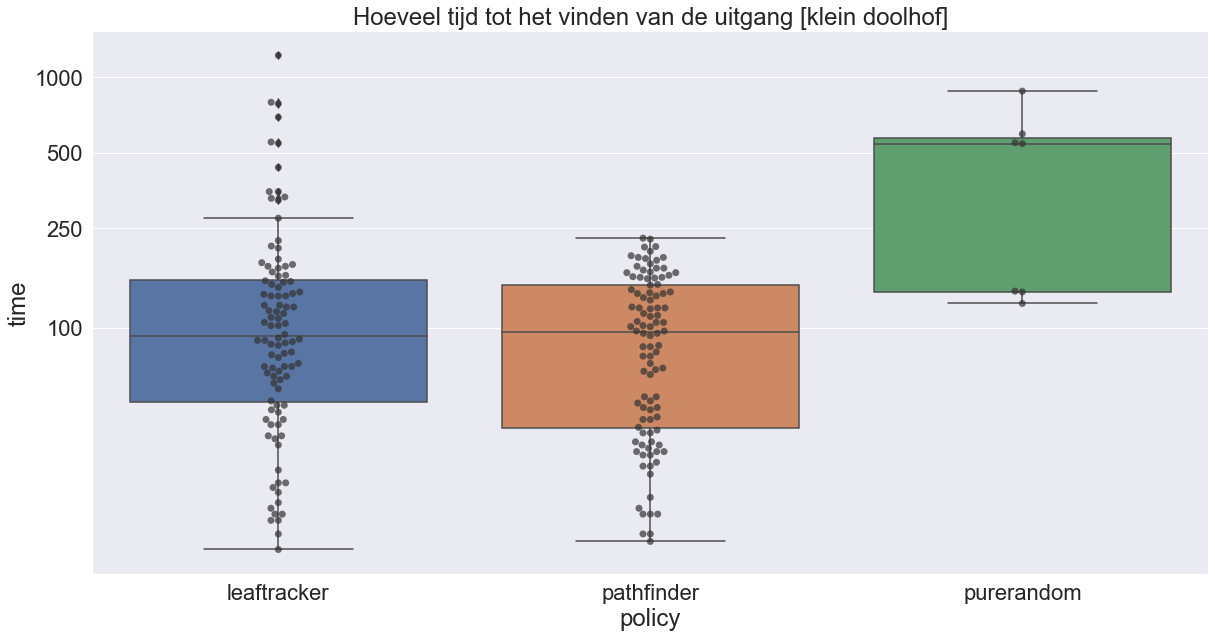

In [184]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=base_small_alive, x='policy', y='time')

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang [klein doolhof]')

ax = sns.swarmplot(data=base_small_alive, x='policy', y='time',color='.2', alpha=0.7, size=7)

### Analyse

Wat hier opvalt is dat er in verschillende simulaties een PureRandom agent is die de uitgang vind zonder dood te gaan. Eigenlijk verwachte we dat dat niet zou gebeuren. Verder lijkt de Leaftracker iets sneller de uitgang te vinden dan de pathfinder.

#### Groot doolhof

- Grootte: 40x40
- 30 batches per policy
- Slowness = 0
- Memory Decay = 0

In [160]:
df_lt = feather.read_feather('baseline/baseline_big/baseline_leaftracker_big.feather').assign(policy='leaftracker')
df_pf = feather.read_feather('baseline/baseline_big/baseline_pathfinder_big.feather').assign(policy='pathfinder')
df_pr = feather.read_feather('baseline/baseline_big/baseline_purerandom_big.feather').assign(policy='purerandom')

base_big_all = pd.concat([df_lt, df_pf, df_pr], axis=0).assign(size='big')
base_big_alive = base_big_all[base_big_all.found_exit != -1]

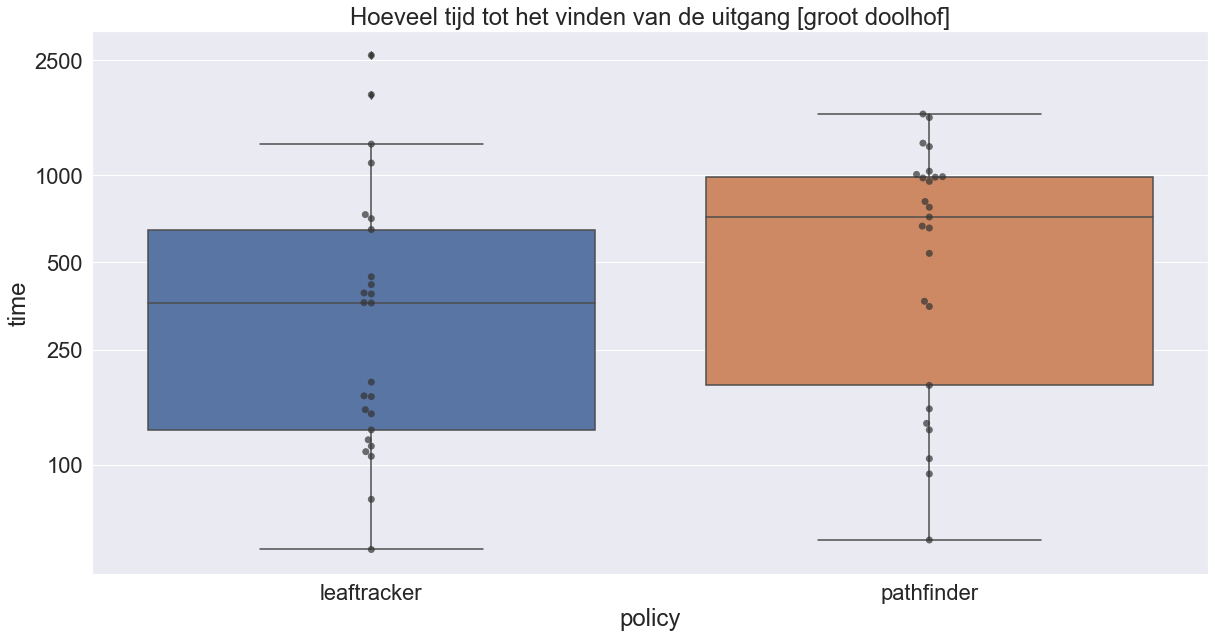

In [177]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=base_big_alive, x='policy', y='time')

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang [groot doolhof]')

ax = sns.swarmplot(data=base_big_alive, x='policy', y='time',color='.2', alpha=0.7, size=7)

### Analyse

Hier zie je dat er geen PureRandom agent meer is die de uitgang kan vinden, wat wel voor te stellen is bij een 40x40 maze. Bij deze lijkt het algoritme van de pathfinder toch beter in het vinden van de buitenkant van de maze en is gemiddeld gezien sneller bij een grotere maze.

In [203]:
df_base_all = pd.concat([base_small_all, base_big_all])
df_base_alive = df_base_all[df_base_all.found_exit != -1]

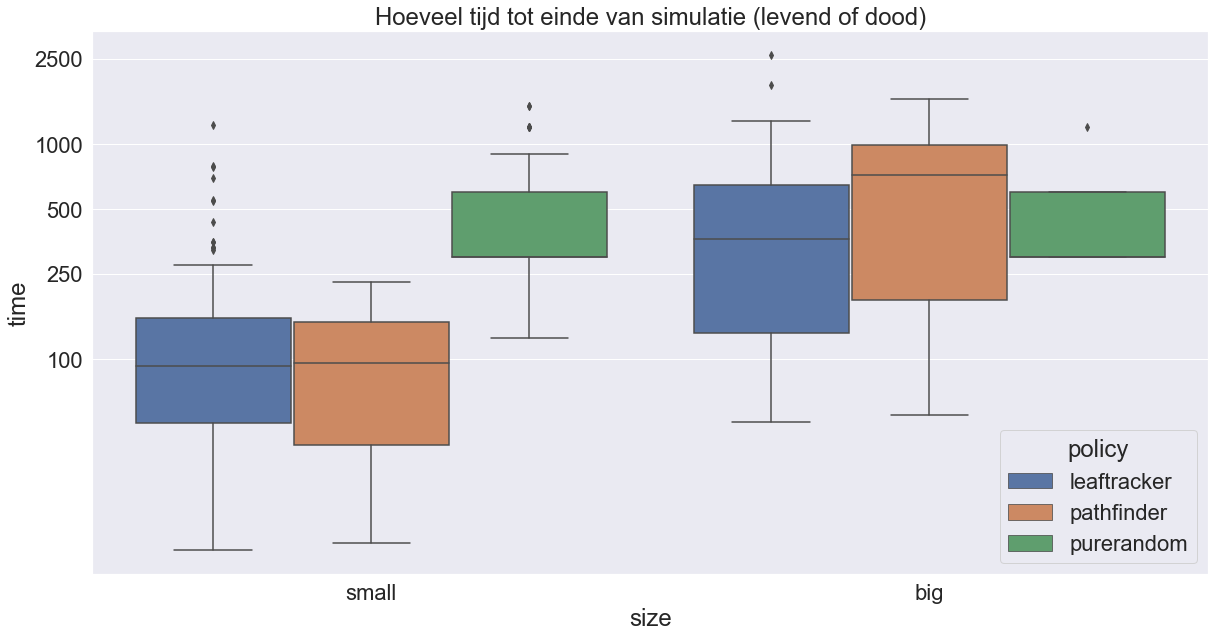

In [204]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_base_all, x='size', y='time', hue='policy', width=0.85)

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot einde van simulatie (levend of dood)')


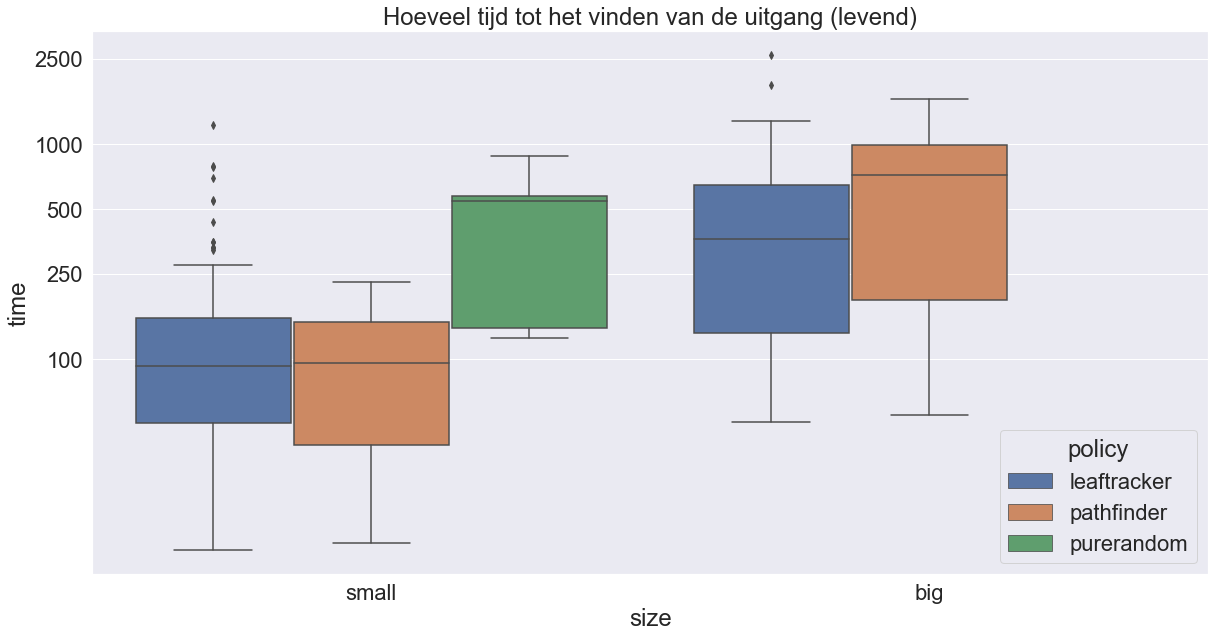

In [181]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=df_base_alive, x='size', y='time', hue='policy', width=0.85)

ax.set_yscale("log")
y_points = [100, 250, 500, 750, 1000, 2500]
ax.set_yticks(y_points)
ax.set_yticklabels(y_points)

ax = ax.set_title('Hoeveel tijd tot het vinden van de uitgang (levend)')

## Slowness

Bij deze analyse laten wij de verschilden snelheden zien van de policies om de uitgang te vinden. Het is verwarrend om het woordje 'snelheid' te gebruiken omdat binnen de simulatie een lage speed juist een snellere agent oplevert. Dit is de rede dat we nu met 'slowness' praten, hoe hoger het getal hoe langzamer de agent is.

- Grootte: 20x20
- ?? batches per policy
- Slowness = Variabel
- Memory Decay = 0

In [27]:
filenames = glob.glob('speed_difference/*.feather')

dfs = []
for filename in filenames:
    # print(filename)
    temp_df = feather.read_feather(filename)
    file_split = filename.split("_")
    policy_type = file_split[3]
    temp_df['slowness'] = int(file_split[4].rsplit(".")[0])
    temp_df['policy'] = policy_type
    dfs.append(temp_df)


# Concatenate all data into one DataFrame
speed_all = pd.concat(dfs, ignore_index=True)
speed_all = speed_all.sort_values(by=['slowness'])
speed_all_alive = speed_all[speed_all.found_exit != -1]


Alleen de agents die overleven en de uitgang vinden

Agent heeft steeds minder tijd om te exploren, daarom exponentieel

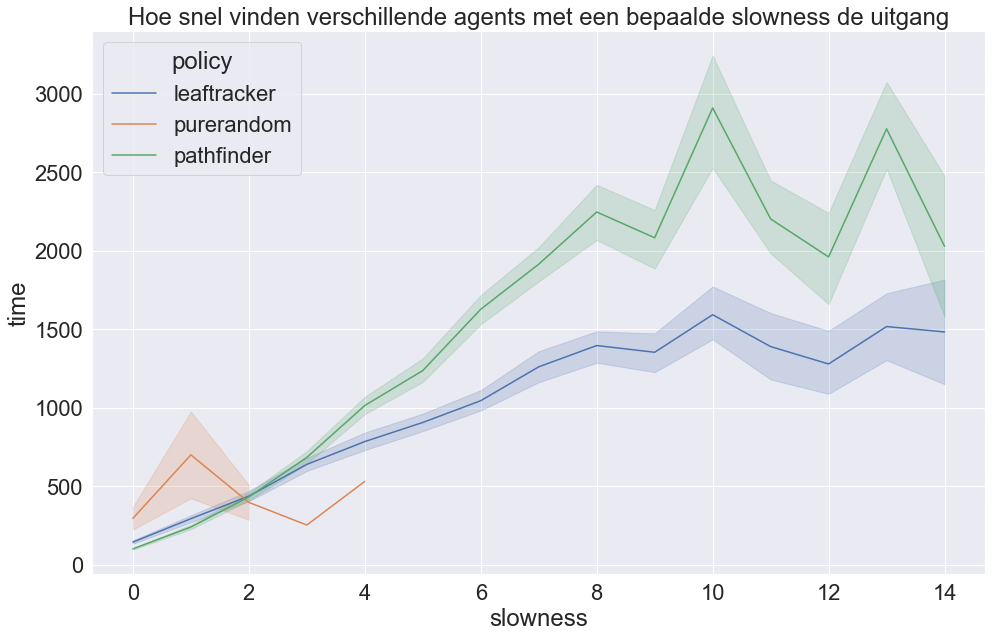

In [28]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data=speed_all_alive, x="slowness", y="time", hue="policy", ci=68)
ax = ax.set_title('Hoe snel vinden verschillende agents met een bepaalde slowness de uitgang')

## Memory decay

Hier gaan we kijken hoeveel memory decay invloed heeft op de tijd die het kost om de uitgang te vinden. Belangrijk is dat memory decay elke nacht gebeurt, wanneer een agent de uitgang in 1 dag vind heeft deze er dus geen last van.

- Grootte: 20x20
- 100 batches per policy
- Slowness = 0
- Memory Decay = Variabel

In [25]:
filenames = glob.glob('memory_decay/*.feather')

dfs = []
for filename in filenames:
    # print(filename)
    temp_df = feather.read_feather(filename)
    file_split = filename.split("_")
    policy_type = file_split[3]
    # print(file_split[4])
    temp_df['decay'] = int(file_split[4].rsplit(".")[0])
    temp_df['policy'] = policy_type
    dfs.append(temp_df)

# Concatenate all data into one DataFrame
decay_all = pd.concat(dfs, ignore_index=True)
decay_all = decay_all.sort_values(by=['decay'])
decay_all_alive = decay_all[decay_all.found_exit != -1]

Text(0.5, 1.0, 'Hoe snel vinden verschillende agents met een bepaalde decay de uitgang')

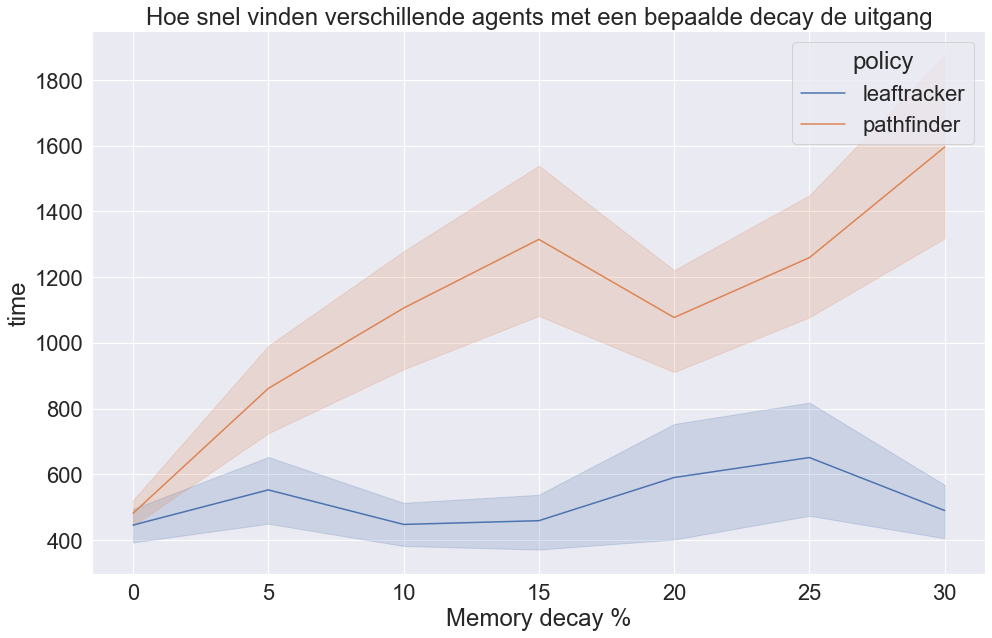

In [24]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(data=decay_all_alive, x="decay", y="time", hue="policy", ci=68)
ax.set(xlabel='Memory decay %')
ax.set_title('Hoe snel vinden verschillende agents met een bepaalde decay de uitgang')



# ax.set(xlabel='common xlabel', ylabel='common ylabel')

### Analsye

Het is te zien dat de leaftracker niet echt beinvloed word door memory decay. Wel zien we bij de pathfinder dat deze omhoog schiet wanneer de agents meer van hun kaart vergeten. Dit komt waarschijnlijk omdat de pathfinding agent dan niet meer met zekerheid een pad kunnen kiezen waar de leaftrackers zich voorral bezig houden met de verspreiding van de blaadjes.

We kunnen de gekke dip bij 20% decay niet direct verklaren, dit zal waarschijlijk niet gebeuren wanneer er heel veel batches gerund zouden worden.

In [12]:
decay_all_alive

,time,found_exit,n_alive,explored,decay,policy
0,87,0,1,"[[[False, False, False, False, False, False, F...",0,leaftracker
1050,158,0,1,"[[[False, False, False, False, False, False, F...",0,pathfinder
1051,148,0,1,"[[[False, False, False, False, False, False, F...",0,pathfinder
1146,638,0,1,"[[[True, True, True, True, True, True, True, T...",0,pathfinder
1147,300,0,1,"[[[True, True, True, True, True, True, True, T...",0,pathfinder
...,...,...,...,...,...,...
1942,5910,0,1,"[[[False, False, True, False, True, True, True...",30,pathfinder
1941,19224,0,1,"[[[True, True, False, False, False, False, Fal...",30,pathfinder
1940,5326,0,1,"[[[True, True, False, True, True, True, True, ...",30,pathfinder
1910,11928,0,1,"[[[False, False, False, False, False, False, F...",30,pathfinder


### Analyse

TODO

![image-2.png](attachment:image-2.png)
